# Predicting whether a customer will default on their loan
---

## The Data:
We will be using a subset of the LendingClub DataSet obtained from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club\n

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.[3] It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.


## The Goal:
Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

The "loan_status" column contain our label


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import mlflow

In [2]:
plt.style.use(['seaborn-talk', 'ggplot'])

## Get and Deal with Missing Values

In [3]:
df = pd.read_csv('lending_club_loan_two.csv')
df_info = pd.read_csv('lending_club_info.csv')

In [4]:
df.head(2)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"


In [5]:
df_info

,LoanStatNew,Description
0,loan_amnt,The listed amount of the loan applied for by t...
1,term,The number of payments on the loan. Values are...
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if th...
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when ap...
7,emp_length,Employment length in years. Possible values ar...
8,home_ownership,The home ownership status provided by the borr...
9,annual_inc,The self-reported annual income provided by th...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


Parse date columns

In [8]:
df.issue_d = pd.to_datetime(df.issue_d)
df['issue_d_year'] = df.issue_d.dt.year
df['issue_d_month'] = df.issue_d.dt.month

In [9]:
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)
df['earliest_cr_line_year'] = df.earliest_cr_line.dt.year
df['earliest_cr_line_month'] = df.earliest_cr_line.dt.month

## Exploratory Data Analysis

We dont have equal sets of both classes. There are a lot more loans which were fully paid off that there were loans which were charged off.

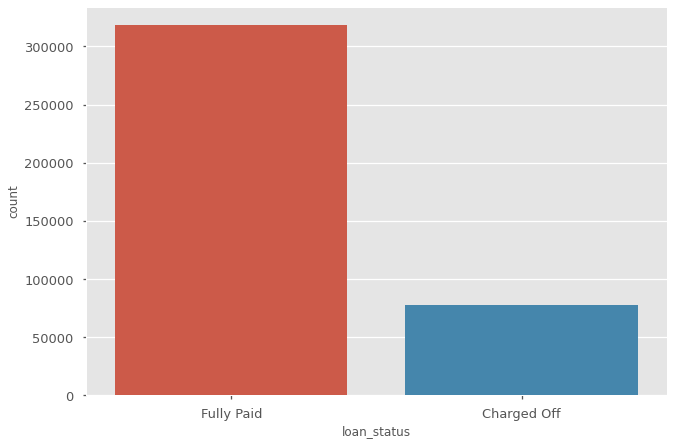

In [10]:
sns.countplot(x='loan_status', data=df)

It looks like loans with 60 months of payments have a much higher default rate than those with 36 months of payments.

Text(0.5, 1.0, '% Number of Loans by Term')

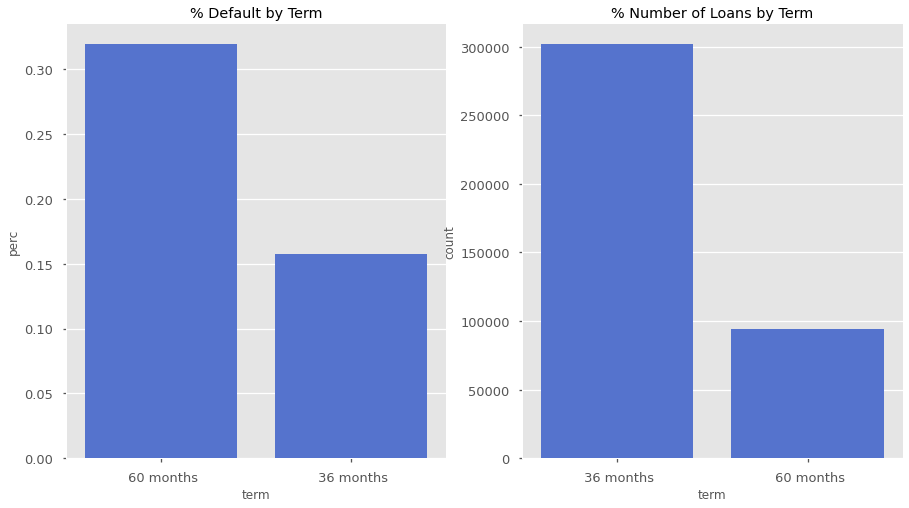

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['term', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='term')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='term', y='perc', color='royalblue', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False),ax=ax[0])
ax[0].set_title('% Default by Term')
sns.countplot(x='term',color='royalblue',data=df,ax=ax[1])
ax[1].set_title('% Number of Loans by Term')

loans which were charged off generally have higher interest rate which makes sense as more riksy loans tend to have higher interest rate

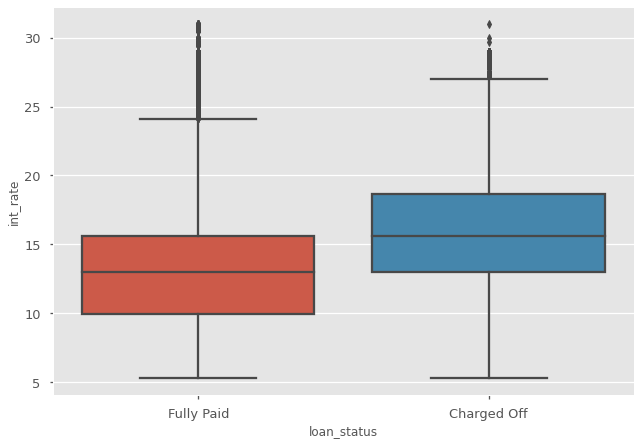

In [12]:
sns.boxplot(x='loan_status', y='int_rate', data=df)

A higher percentage of lower grade are charged off than those higher grade.

Text(0.5, 1.0, 'Count by grade')

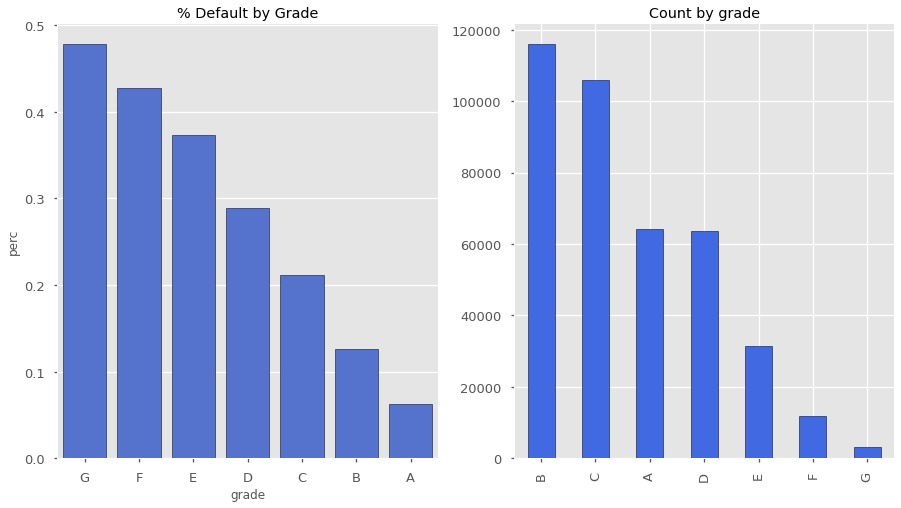

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['grade', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='grade')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='grade', y='perc', color='royalblue', edgecolor='black', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by Grade')
df['grade'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black', ax=ax[1])
ax[1].set_title('Count by grade')

The data suggests that the people who rent are more likely to default on their loan than people who own their home. who themselves are more likely to default on their loan than people with Mortgatest. However a vast majority of the loans are to people who either Rent or pay a mortgage.

Text(0.5, 1.0, 'Count by home_ownership')

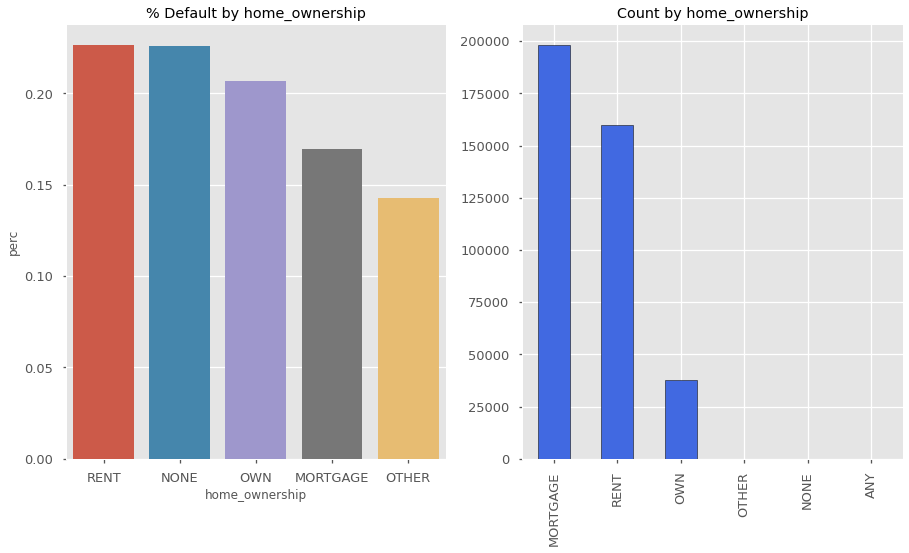

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['home_ownership', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='home_ownership')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='home_ownership', y='perc', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by home_ownership')
df['home_ownership'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black', ax=ax[1])
ax[1].set_title('Count by home_ownership')

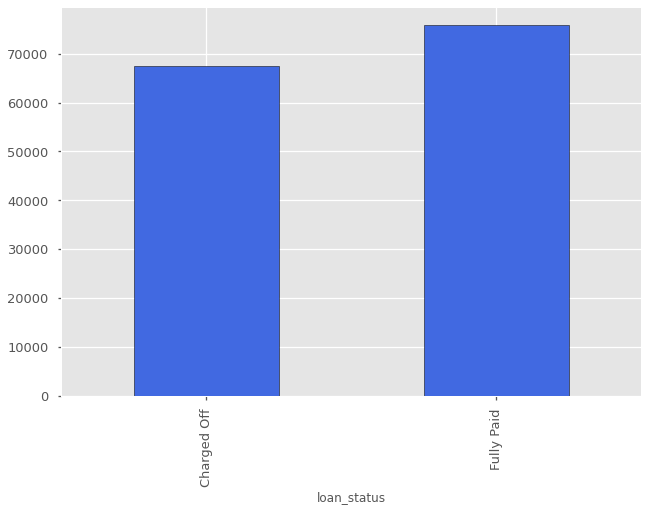

In [15]:
df.groupby('loan_status')['annual_inc'].mean().plot(kind='bar', color='royalblue', edgecolor='black')

Text(0.5, 1.0, 'Count by verification_status')

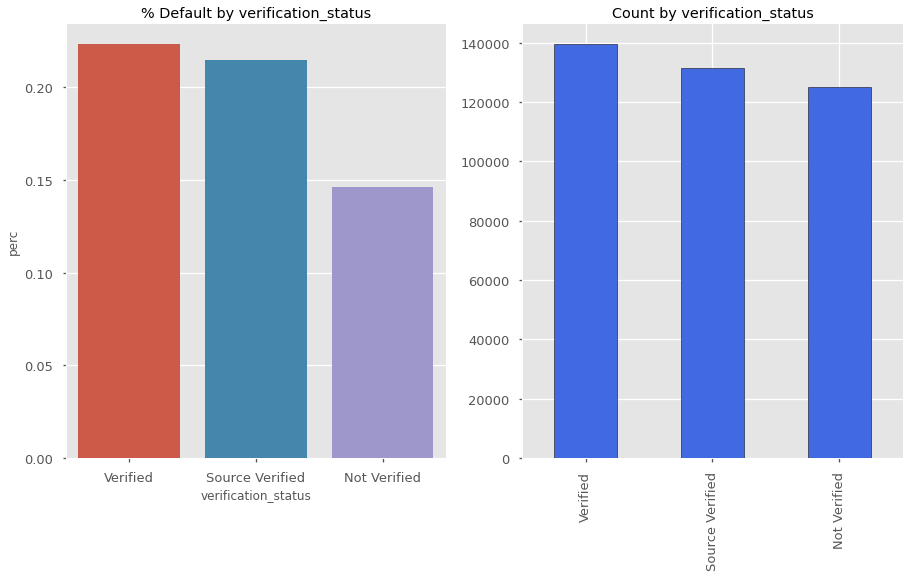

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['verification_status', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='verification_status')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='verification_status', y='perc', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by verification_status')
df['verification_status'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black', ax=ax[1])
ax[1].set_title('Count by verification_status')

Text(0.5, 1.0, 'Count by issue_d_year')

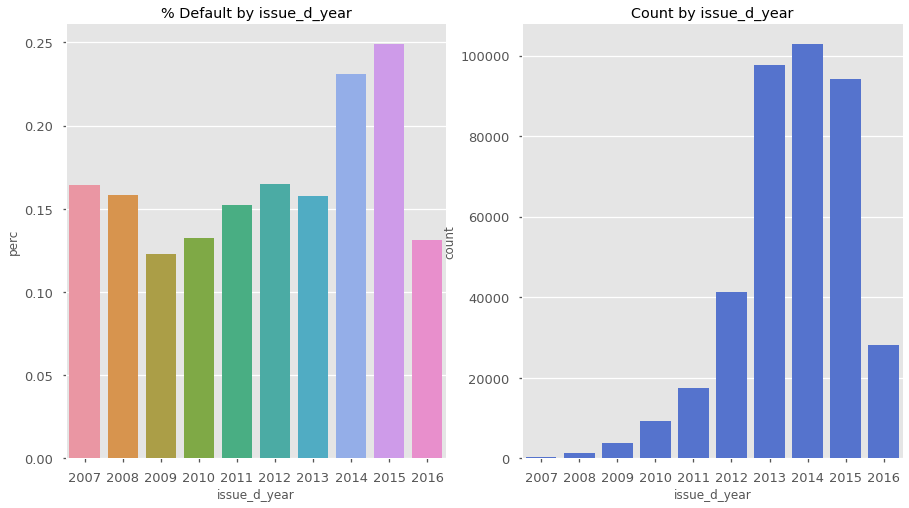

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['issue_d_year', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='issue_d_year')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='issue_d_year', y='perc', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by issue_d_year')
sns.countplot(df['issue_d_year'], ax=ax[1], color='royalblue')
ax[1].set_title('Count by issue_d_year')

Text(0.5, 1.0, 'Count by purpose')

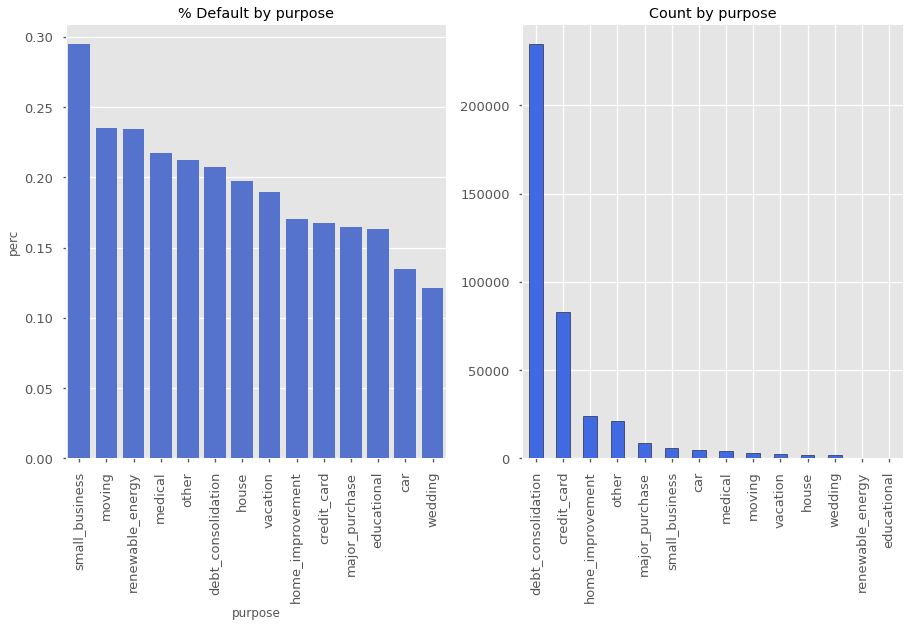

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['purpose', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='purpose')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='purpose', y='perc', color='royalblue', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by purpose')
ax[0].tick_params(axis='x', labelrotation=90)
df['purpose'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black', ax=ax[1])
ax[1].set_title('Count by purpose')

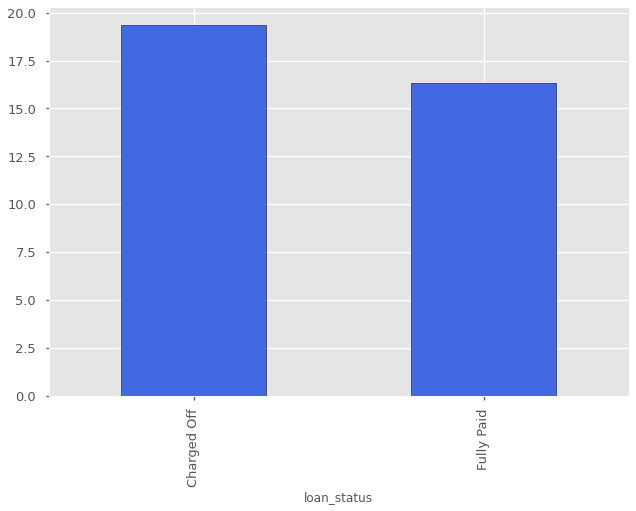

In [19]:
df.groupby('loan_status')['dti'].median().plot(kind='bar', color='royalblue', edgecolor='black')

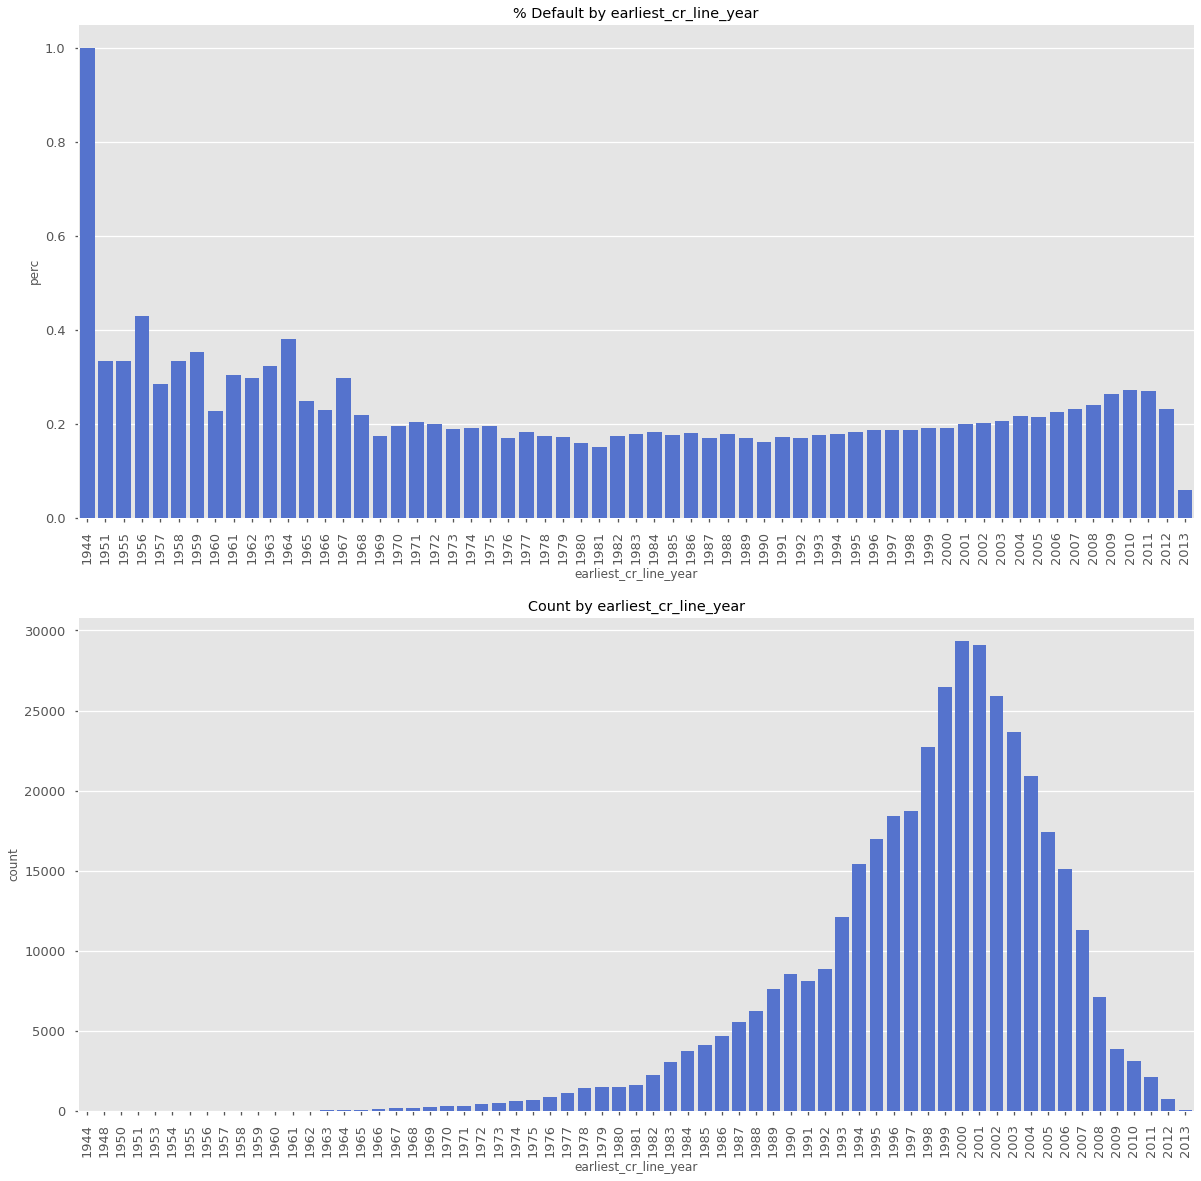

In [20]:
fig, ax = plt.subplots(2,1, figsize=(20,20) )
plot = df.groupby(by=['earliest_cr_line_year', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='earliest_cr_line_year')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='earliest_cr_line_year', y='perc', color='royalblue', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by earliest_cr_line_year')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(df['earliest_cr_line_year'], ax=ax[1], color='royalblue')
ax[1].set_title('Count by earliest_cr_line_year')
ax[1].tick_params(axis='x', labelrotation=90)

Text(0.5, 1.0, 'Count by application_type')

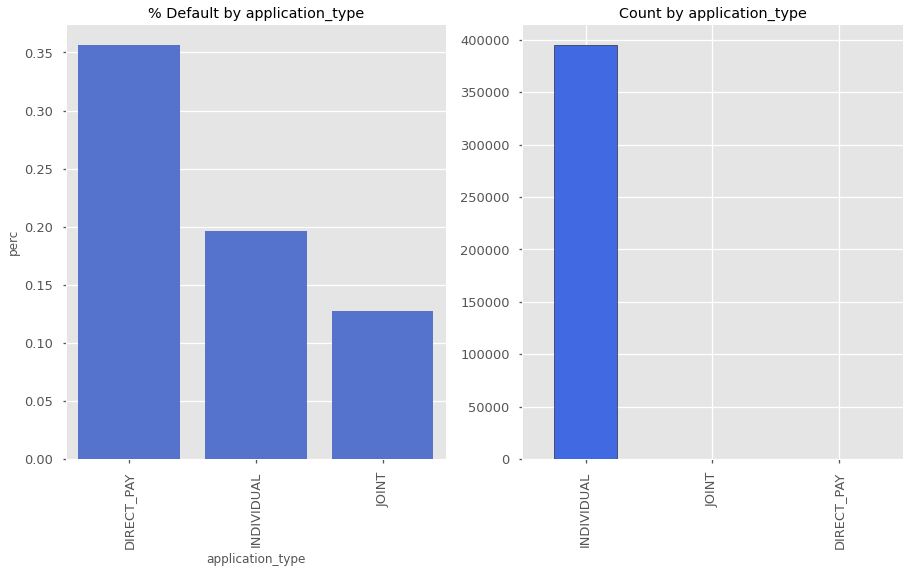

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['application_type', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='application_type')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='application_type', y='perc', color='royalblue', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by application_type')
ax[0].tick_params(axis='x', labelrotation=90)
df['application_type'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black', ax=ax[1])
ax[1].set_title('Count by application_type')

Text(0.5, 1.0, 'Count by pub_rec_bankruptcies')

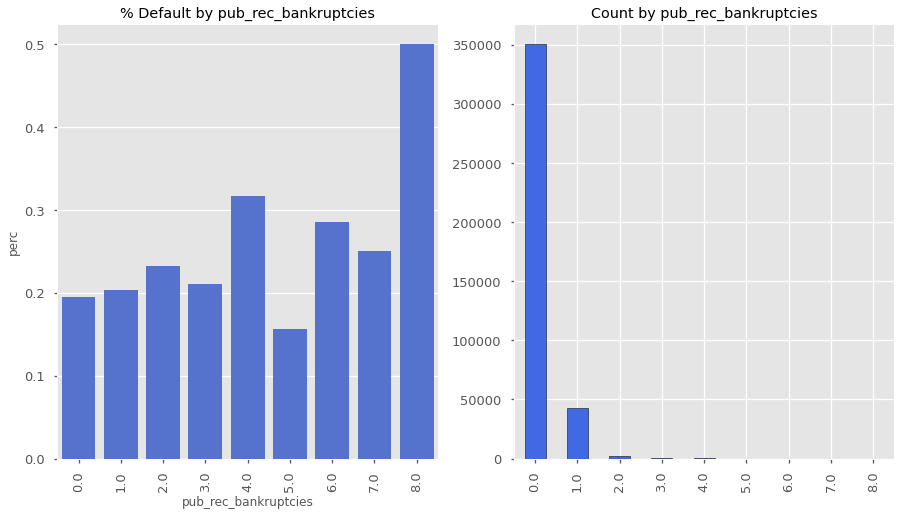

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,8) )
plot = df.groupby(by=['pub_rec_bankruptcies', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='pub_rec_bankruptcies')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='pub_rec_bankruptcies', y='perc', color='royalblue', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False), ax=ax[0])
ax[0].set_title('% Default by pub_rec_bankruptcies')
ax[0].tick_params(axis='x', labelrotation=90)
df['pub_rec_bankruptcies'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black', ax=ax[1])
ax[1].set_title('Count by pub_rec_bankruptcies')

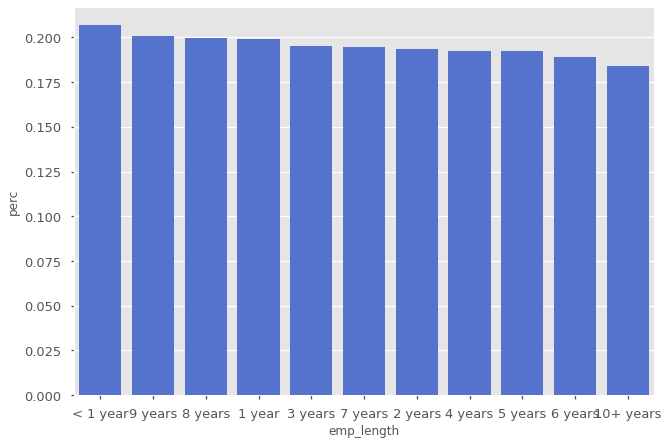

In [23]:
plot = df.groupby(by=['emp_length', 'loan_status'])['term'].count().to_frame('count').reset_index()
plot['total'] = plot.groupby(by='emp_length')['count'].transform('sum')
plot['perc'] = plot.eval('count / total')
sns.barplot(x='emp_length', y='perc', color='royalblue', data=plot[plot.loan_status=='Charged Off'].sort_values(by='perc', ascending=False))

## Dealing with Missing Values

Columns with missing values and the % of values that are missing. 

In [24]:
col_na = df.columns[df.isna().any()]
100 * df[ col_na ].isna().sum()/ len(df)

emp_title               5.789208
emp_length              4.621115
title                   0.443148
revol_util              0.069692
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
dtype: float64

We dont care about null values in the following columns as these will be dropped later on:
- emp_title, there are too many catogories
- emp_length, the % of people that default barely differs per employment catogories
- title, repeat of the purpose column 

Remove rows with any missing data in the below columns. Very little amount of data will be lost

In [25]:
df.dropna(inplace=True, subset=['revol_util', 'pub_rec_bankruptcies'])

Fill in data for mortgage accounts by using the total_acc as it has the highest correlation. 

In [26]:
df.corr()['mort_acc'].drop('mort_acc').sort_values()

earliest_cr_line_year    -0.291318
int_rate                 -0.082656
dti                      -0.025401
earliest_cr_line_month   -0.019522
issue_d_month            -0.006727
revol_util                0.007514
issue_d_year              0.011254
pub_rec                   0.011576
pub_rec_bankruptcies      0.027273
open_acc                  0.109440
installment               0.193752
revol_bal                 0.195063
loan_amnt                 0.222381
annual_inc                0.236277
total_acc                 0.381205
Name: mort_acc, dtype: float64

In [27]:
t_avg = df.groupby('total_acc')['mort_acc'].mean()

In [28]:
df.loc[df.mort_acc.isna(), 'mort_acc'] = t_avg.loc[df.loc[df.mort_acc.isna(), 'total_acc']].values

## Feature Engineering

Removing features that i dont need

Below is a list of non quantitative variables

In [29]:
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'purpose',
       'title', 'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [30]:
df.term = df.term.apply(lambda x: int(x[:3])) # Converted into a numeric

As we found out from the EDA there are very few data points with home_ownership as NONE or ANY so will just dump them into OTHER

In [31]:
df.home_ownership = df.home_ownership.replace(['NONE', 'ANY'], 'OTHER')

Extract the zipcode from the address column and see if it can be used as a feature

In [32]:
df['zipcode'] = df.address.apply(lambda x: x[-5:])

In [33]:
df.zipcode.unique()

array(['22690', '05113', '00813', '11650', '30723', '70466', '29597',
       '48052', '86630', '93700'], dtype=object)

In [34]:
df.drop(columns=[
    'earliest_cr_line',
    'earliest_cr_line_month',
    'issue_d', #data leakage 
    'issue_d_year',
    'issue_d_month',
    'title',
    'emp_length',
    'emp_title',
    'grade',
    'address'
], inplace=True)

Create dummy variables

In [35]:
dum_col = [
    'application_type', 'initial_list_status', 'purpose', 
    'verification_status', 'home_ownership',
    'sub_grade', 'zipcode'
]

In [36]:
for col in dum_col:
    df = df.join(pd.get_dummies(df[col], prefix=col, drop_first=True)).drop(col, axis=1)

In [37]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':0, 'Charged Off': 1})

## Feature Importance

Training data is 80%, Validation data is 15% and test data is %5

In [38]:
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.95*len(df))])

In [39]:
X_train, y_train = train.drop('loan_status', axis=1).values, train['loan_status'].values

In [40]:
X_valid, y_valid = validate.drop('loan_status', axis=1).values, validate['loan_status'].values

In [41]:
X_test, y_test = test.drop('loan_status', axis=1).values, test['loan_status'].values

In [42]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [43]:
rfr = RandomForestClassifier(n_estimators=100)

In [44]:
rfr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
fi = pd.DataFrame(np.c_[df.drop('loan_status',axis=1).columns, rfr.feature_importances_], columns=['feature', 'importance'])

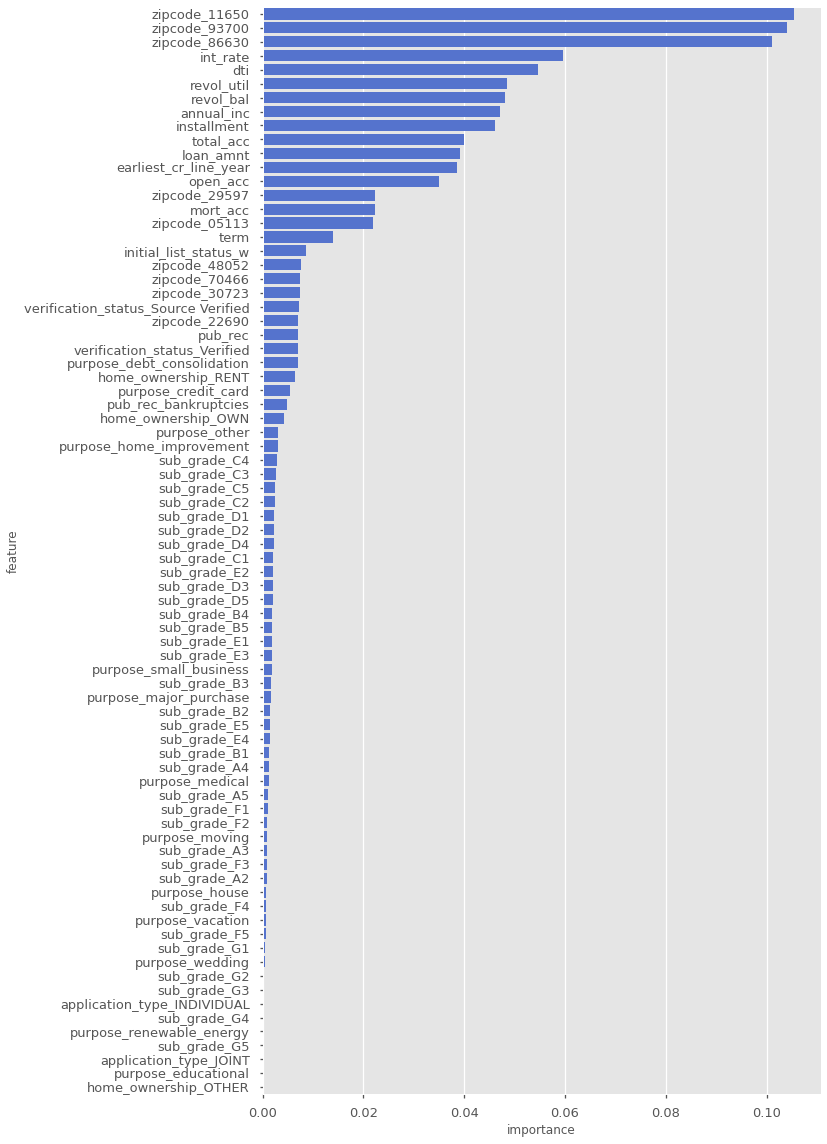

In [46]:
plt.figure(figsize=(10,20))
sns.barplot(y='feature', x='importance', data=fi.sort_values('importance', ascending=False), color='royalblue')

## Train and Evaluate the Model

In [47]:
no_features = X_train.shape[1]
no_features

78

Rule of thumb that i have picked up by reading data science forums:
- Input Layer: Number units should be the number of features
- Hidden Layer: Number of units should be average of Number of units in the inuput and Number of units in the output. In general try and stick to one
- Output Layer: if its a regression or binary classification then 1, else for mult class classification should be equal to the number of classes

In [104]:
model = Sequential()

model.add(Dense(78, activation='relu', input_dim=no_features))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

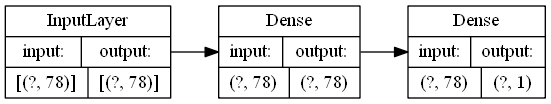

In [105]:
plot_model(model, show_shapes=True, show_layer_names=False,
    rankdir='LR', expand_nested=True, dpi=96, to_file='model.png'
)

In [106]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [107]:
model.fit(
    X_train, 
    y_train, 
    epochs=600, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop],
    batch_size=256
)

Train on 316175 samples, validate on 59283 samples
Epoch 1/600
316175/316175 [==============================] - 3s 10us/sample - loss: 0.2862 - val_loss: 0.2606
Epoch 2/600
316175/316175 [==============================] - 3s 9us/sample - loss: 0.2599 - val_loss: 0.2587
Epoch 3/600
316175/316175 [==============================] - 3s 9us/sample - loss: 0.2575 - val_loss: 0.2570
Epoch 4/600
316175/316175 [==============================] - 3s 10us/sample - loss: 0.2563 - val_loss: 0.2566
Epoch 5/600
316175/316175 [==============================] - 3s 10us/sample - loss: 0.2554 - val_loss: 0.2559
Epoch 6/600
316175/316175 [==============================] - 3s 10us/sample - loss: 0.2547 - val_loss: 0.2564
Epoch 7/600
316175/316175 [==============================] - 4s 12us/sample - loss: 0.2543 - val_loss: 0.2570
Epoch 8/600
316175/316175 [==============================] - 3s 10us/sample - loss: 0.2539 - val_loss: 0.2563
Epoch 9/600
316175/316175 [==============================] - 4s 11us/sa

In [108]:
val_predict = model.predict_classes(X_valid)
tn, fp, fn, tp = confusion_matrix(y_valid, val_predict).ravel()

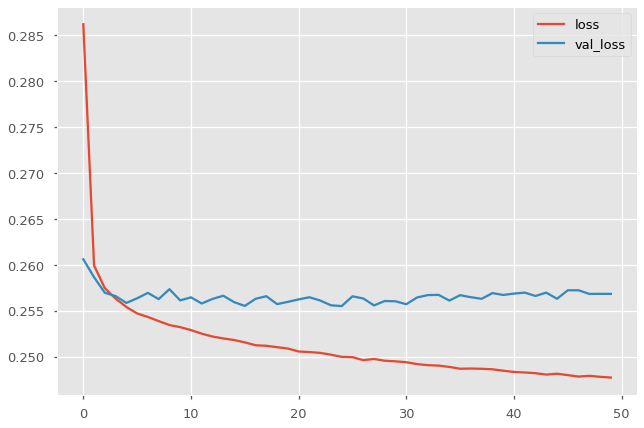

In [109]:
loss = pd.DataFrame(model.history.history)
p = loss.plot()
plt.savefig('loss.png')

In [110]:
print(classification_report(y_valid, val_predict))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     47812
           1       0.90      0.49      0.63     11471

    accuracy                           0.89     59283
   macro avg       0.89      0.74      0.78     59283
weighted avg       0.89      0.89      0.88     59283



In [111]:
with mlflow.start_run() as run:
    mlflow.log_param('crossval', 'train test split')
    mlflow.log_metric('recall', (tp / (tp + fn))*100)
    mlflow.log_metric('precision', (tp / (tp + fp))*100)
    mlflow.log_artifact('model.png')
    mlflow.log_artifact('loss.png')

- After multiple runs, which were tracketd with mlflow, the above is the best configuiration i could come up with. It has a ***recall of 51%*** and a ***precision of 89%*** against the validation data. 
- Hence out of all the loans that were defaulted on we were able to predict half of them correctly and out of all the loans we predicted will defualt 89% of those actually did.

## Test the model

In [87]:
pred = model.predict_classes(X_test)

In [88]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     15859
           1       0.84      0.50      0.63      3902

    accuracy                           0.88     19761
   macro avg       0.86      0.74      0.78     19761
weighted avg       0.88      0.88      0.87     19761



## Lessons Learnt

Lessons learnt from this project:
- When examining missing data do not drop rows with missisng data if the means lossing a significant amount of data
- StandardScaler can be used on dummy variables as well
- df.corr()['target'] to find out correlation between target and qualitative features 
- when creating dummy variables remember to drop first
- look out for columns that may cause data leakage
- ANNs reqire a lot experimentation 
- good features make all the difference

# END